In [33]:
# generic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# project specific custom libraries
from config import *
from simulation import simulate_decay_times
from analysis import *

from joblib import delayed, Parallel

In [34]:
#set a seed for numpys random number generator
# np.random.seed(42)

In [35]:
t_bounds = [0, 20000e-9]
n = 10000
n_sims = 1000

MUON_estimate = 2e-6
PION_estimate = 1.2e-8
initial_guess = [MUON_estimate, PION_estimate]

In [36]:
def simulation(n, t_bounds, initial_guess, bounds=(-np.inf, np.inf)):

    simulated_decay_points = simulate_decay_times(n, t_bounds[1])
    counts, bins = np.histogram(simulated_decay_points[:, 0] , bins=35, density=False)

    return binned_least_squares_fit(counts, bins, initial_guess, bounds)

In [37]:
# simulation_results = [simulation(n, t_bounds, initial_guess) for _ in range(n_sims)]
simulation_results = Parallel(n_jobs=-1)(delayed(simulation)(n, t_bounds, initial_guess) for _ in range(n_sims))

/Users/tillboehringer/Dropbox/Studium/Physik/Semester4/PHY241_Project/PHY241/Code/analysis.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(N_wrapper, bin_centers, counts, p0=initial_guess, bounds=bounds)
/Users/tillboehringer/Dropbox/Studium/Physik/Semester4/PHY241_Project/PHY241/Code/analysis.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(N_wrapper, bin_centers, counts, p0=initial_guess, bounds=bounds)
/Users/tillboehringer/Dropbox/Studium/Physik/Semester4/PHY241_Project/PHY241/Code/analysis.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(N_wrapper, bin_centers, counts, p0=initial_guess, bounds=bounds)


In [38]:
simulation_results = pd.DataFrame(np.array(simulation_results), columns=['MUON_estimate', 'PION_estimate', 'MUON_uncer', 'PION_uncer'])
simulation_results.replace([np.inf, -np.inf], np.nan, inplace=True)
simulation_results.dropna(inplace=True)

In [39]:
simulation_results

,MUON_estimate,PION_estimate,MUON_uncer,PION_uncer
0,0.000002,2.501415e-08,2.675543e-08,1.884463e-08
1,0.000002,9.343475e-08,1.801798e-08,5.499304e-09
2,0.000002,7.477099e-08,2.071946e-08,6.960962e-09
3,0.000002,2.634528e-08,1.655303e-08,1.169596e-08
4,0.000002,1.433481e-08,2.170725e-08,1.512245e-08
...,...,...,...,...
994,0.000002,1.910164e-08,2.085816e-08,1.450679e-08
995,0.000002,2.795002e-08,2.629947e-08,1.879641e-08
996,0.000002,8.266284e-08,1.779391e-08,5.632755e-09
997,0.000002,5.511031e-08,1.409039e-08,1.072412e-08


In [40]:
MUON_mean = simulation_results['MUON_estimate'].mean()
PION_mean = simulation_results['PION_estimate'].mean()
MUON_uncer = np.sqrt(np.mean(np.power(simulation_results['MUON_uncer'],2)))
PION_uncer = np.sqrt(np.mean(np.power(simulation_results['PION_uncer'],2)))
print(MUON_uncer)

2.161430412074037e-08


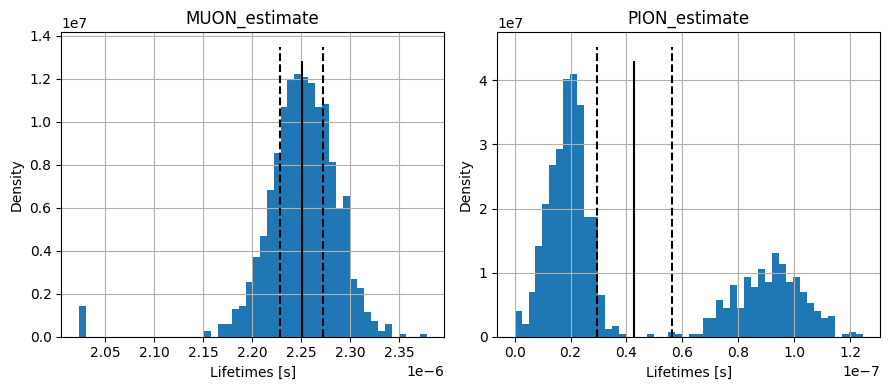

In [41]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9,4))
simulation_results.hist(column=['MUON_estimate'], ax=ax[0], bins=50, density=True)
simulation_results.hist(column=['PION_estimate'], ax=ax[1], bins=50, density=True)
for i in ax:
    i.set_ylabel('Density')
    i.set_xlabel('Lifetimes [s]')

ax[0].vlines(MUON_mean, *ax[0].get_ylim(), color='k')
ax[1].vlines(PION_mean, *ax[1].get_ylim(), color='k')

ax[0].vlines([MUON_mean + MUON_uncer, MUON_mean - MUON_uncer], *ax[0].get_ylim(), color='k', linestyle='--')
ax[1].vlines([PION_mean + PION_uncer, PION_mean - PION_uncer], *ax[1].get_ylim(), color='k', linestyle='--')

plt.tight_layout()

In [51]:
bounds = ([-np.inf, 0.1e-10],[np.inf, 0.5e-7])
# simulation_results_bounded = [simulation(n, t_bounds, initial_guess, bounds=bounds) for _ in range(n_sims)]
simulation_results_bounded = Parallel(n_jobs=-1)(delayed(simulation)(n, t_bounds, initial_guess, bounds=bounds) for _ in range(n_sims))
simulation_results_bounded = pd.DataFrame(np.array(simulation_results_bounded), columns=['MUON_estimate', 'PION_estimate', 'MUON_uncer', 'PION_uncer'])
simulation_results_bounded.replace([np.inf, -np.inf], np.nan, inplace=True)
simulation_results_bounded.dropna(inplace=True)

simulation_results_bounded = simulation_results_bounded[simulation_results_bounded['PION_estimate'] < 4.5e-8]

MUON_mean_bounded = simulation_results_bounded['MUON_estimate'].mean()
PION_mean_bounded = simulation_results_bounded['PION_estimate'].mean()
MUON_uncer_bounded = np.sqrt(np.mean(np.power(simulation_results_bounded['MUON_uncer'],2)))
PION_uncer_bounded = np.sqrt(np.mean(np.power(simulation_results_bounded['PION_uncer'],2)))

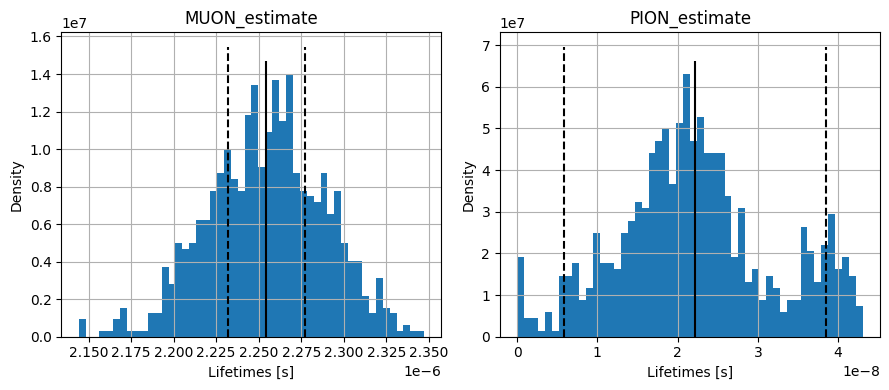

In [52]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9,4))
simulation_results_bounded.hist(column=['MUON_estimate'], ax=ax[0], bins=50, density=True)
simulation_results_bounded.hist(column=['PION_estimate'], ax=ax[1], bins=50, density=True)
for i in ax:
    i.set_ylabel('Density')
    i.set_xlabel('Lifetimes [s]')

ax[0].vlines(MUON_mean_bounded, *ax[0].get_ylim(), color='k')
ax[1].vlines(PION_mean_bounded, *ax[1].get_ylim(), color='k')

ax[0].vlines([MUON_mean_bounded + MUON_uncer_bounded, MUON_mean_bounded - MUON_uncer_bounded], *ax[0].get_ylim(), color='k', linestyle='--')
ax[1].vlines([PION_mean_bounded + PION_uncer_bounded, PION_mean_bounded - PION_uncer_bounded], *ax[1].get_ylim(), color='k', linestyle='--')

plt.tight_layout()